In [1]:
import pandas as pd
import numpy as np
import torch
import os
import optuna
import xgboost as xgb
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

c:\Users\10\anaconda3\envs\hw1_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Baseline Model
### Dataset

In [3]:
class BaselineDataset(Dataset):
    def __init__(self, path=TRAIN_PATH):
        self.data = []
        self.target = []
        for file in os.listdir(path):
            df = pd.read_csv(path + file, sep='|')
            df = df.fillna(method='ffill') # if possible fill with previous value
            df = df.fillna(0) # else fill with 0
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            self.target.append(1 if sepsis_index else 0)
            self.data.append(torch.Tensor(df.drop('SepsisLabel', axis=1).iloc[-1] if sepsis_index is None else df.drop('SepsisLabel', axis=1).iloc[sepsis_index]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

### Model

In [8]:
class Model(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, output_size=2, activation='ReLU', dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.sequence = nn.Sequential(self.fc1, getattr(nn, activation)(), nn.Dropout(p=dropout), self.fc2, 
                                      getattr(nn, activation)(), nn.Dropout(p=dropout), self.fc3, getattr(nn, activation)())

    def forward(self, x):
        return self.sequence(x)

### Hyperparameter Tuning

In [74]:
train_set = BaselineDataset()
test_set = BaselineDataset(path=TEST_PATH)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [ ]:
count_zero = sum([1 for i in train_set.target if i == 0])
count_one = 20000 - count_zero

In [3]:
def train(loss_fn, optimizer, model,  train_dataloader, test_dataloader, device=device, epochs=20, save_best=False, save_name='best_baseline_model.pt', accumulate_grad=False, batch_size=32):
    train_losses = []
    test_losses = []
    train_f1_scores = []
    test_f1_scores = []
    max_f1_score = 0
    optimizer.zero_grad()
    for i in range(epochs):
        model.train()
        train_loss = 0
        train_f1_score = 0
        for j, data in enumerate(train_dataloader):
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            train_f1_score += f1_score(target.to(torch.device('cpu')), pred.to(torch.device('cpu')))
            loss = loss_fn(output, target)
            train_loss += loss.item()
            if accumulate_grad:
                loss = loss/batch_size
            loss.backward()
            if not accumulate_grad or j+1 % batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
        if accumulate_grad and j+1 % batch_size != 0:
            optimizer.step()
            optimizer.zero_grad()
        train_f1_scores.append(train_f1_score/len(train_dataloader))
        train_losses.append(train_loss/len(train_dataloader))
        test_loss, test_f1_score = activity(model, test_dataloader, loss_fn, device)
        test_losses.append(test_loss)
        test_f1_scores.append(test_f1_score)
        if save_best and test_f1_score > max_f1_score:
            max_f1_score = test_f1_score
            torch.save(model, save_name)
        if ((i+1) % 1) == 0:
            print('Epoch: {} Train Loss: {} Test Loss: {}'.format(i+1, train_losses[-1], test_losses[-1]))
    return train_losses, test_losses, train_f1_scores, test_f1_scores

def activity(model, test_dataloader, loss_fn, device):
    model.eval()
    preds = []
    targets = []
    test_loss = 0
    test_f1_score = 0
    with torch.no_grad():
        for data in test_dataloader:
            input, target = data
            input = input.to(device)
            target = target.to(device)
            output = model(input)
            pred = torch.argmax(output, dim=1)
            preds.append(pred)
            targets.append(target)
            loss = loss_fn(output, target)
            test_loss += loss.item()
        return test_loss/len(test_dataloader), f1_score(torch.cat(targets).to(torch.device('cpu')), torch.cat(preds).to(torch.device('cpu')))


In [ ]:

def objective(trial):
    epochs = 15
    hidden_size = trial.suggest_int('hidden_size', 32, 512)
    activation = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh', 'Sigmoid'])
    dropout = trial.suggest_float('dropout', 0, 0.5)
    model = Model(hidden_size=hidden_size, activation=activation, dropout=dropout).to(device)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'Adagrad', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(weight=torch.tensor([count_zero/count_zero, count_zero/count_one]).to(device))
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, device, epochs)
    return max(test_f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

In [124]:
study.best_params

{'hidden_size': 339,
 'activation': 'LeakyReLU',
 'dropout': 0.0452953515714292,
 'optimizer': 'Adagrad',
 'lr': 0.03580171856349014}

In [70]:
best_params = {'hidden_size': 339,
 'activation': 'LeakyReLU',
 'dropout': 0.0452953515714292,
 'optimizer': 'Adagrad',
 'lr': 0.03580171856349014}
epochs = 100
model = Model(hidden_size=best_params['hidden_size'], activation=best_params['activation']).to(device)
optimizer = getattr(torch.optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'])
loss = nn.CrossEntropyLoss()
train_losses, test_losses, train_f1_scores, test_f1_scores = train(loss, optimizer, model, train_dataloader, test_dataloader, epochs=epochs, save_best=True, save_name='best_baseline_model.pt')

Epoch: 1 Train Loss: 0.3239398565709591 Test Loss: 0.22464070208489703
Epoch: 2 Train Loss: 0.22743317961096762 Test Loss: 0.21557138916164542
Epoch: 3 Train Loss: 0.22161772315204142 Test Loss: 0.21592144252726445
Epoch: 4 Train Loss: 0.21289534406661986 Test Loss: 0.21086888773420367
Epoch: 5 Train Loss: 0.20755932922959328 Test Loss: 0.20800114277833567
Epoch: 6 Train Loss: 0.20771327065229417 Test Loss: 0.20848824852666917
Epoch: 7 Train Loss: 0.20533791713118554 Test Loss: 0.20681624647717886
Epoch: 8 Train Loss: 0.20332381292581558 Test Loss: 0.20527483480045208
Epoch: 9 Train Loss: 0.20125451920628548 Test Loss: 0.20805077558865373
Epoch: 10 Train Loss: 0.19953041034042834 Test Loss: 0.2028126337062627
Epoch: 11 Train Loss: 0.1990861210912466 Test Loss: 0.20188332058060854
Epoch: 12 Train Loss: 0.19822140167951585 Test Loss: 0.20148866053539724
Epoch: 13 Train Loss: 0.19741452629566192 Test Loss: 0.20098647815636553
Epoch: 14 Train Loss: 0.19482539281845093 Test Loss: 0.19951037

In [ ]:
model = torch.load('best_baseline_model.pt').to(device)
model.eval()
f = f1_score(np.array(test_set.target), np.argmax(model(torch.cat(test_set.data).view(-1, 40).to(device)).to(torch.device('cpu')).detach().numpy(), axis=1))
print(f)

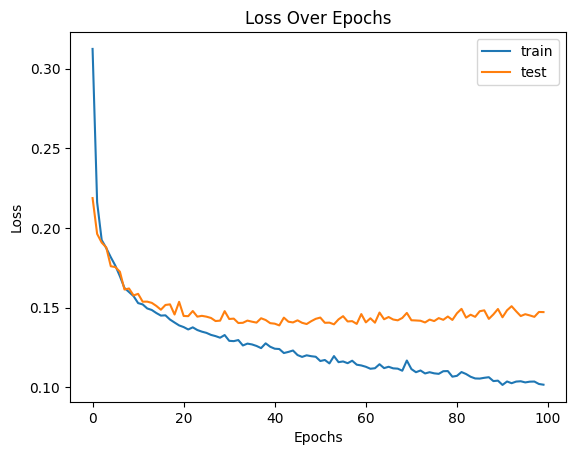

In [24]:
sns.lineplot(train_losses, label='train')
sns.lineplot(test_losses, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/baseline_loss.png', dpi=1200)
plt.show()

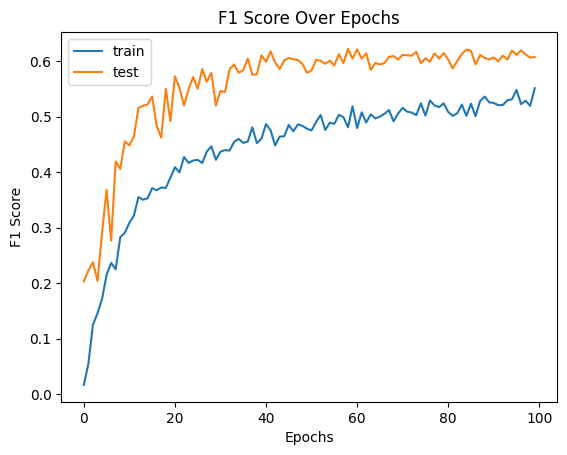

In [25]:
sns.lineplot(train_f1_scores, label='train')
sns.lineplot(test_f1_scores, label='test')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/baseline_f1.png', dpi=1200)
plt.show()

In [26]:
print(f'Best model achieved at epoch {np.argmax(test_f1_scores)} with F1 score {np.max(test_f1_scores)}')

Best model achieved at epoch 58 with F1 score 0.6222222222222221


In [94]:
model = torch.load('best_baseline_model.pt').to(device)
model.eval()
pred = np.argmax(model(torch.cat(test_set.data).view(-1, 40).to(device)).to(torch.device('cpu')).detach().numpy(), axis=1)
real = np.array(test_set.target)
sum(pred == real)/len(pred)

0.9592

In [34]:
sum([1 if i == 0 else 0 for i in real])/len(pred)

0.9364

In [74]:
def permutation_feature_importance(model, criterion, test_data, test_target, column_names, lstm=False, device=torch.device('cuda:0')):
    losses = {}
    model.eval()
    model = model.to(device)
    data = torch.cat(test_data).view(-1, test_data[0].shape[0]) if not lstm else torch.cat(test_data).view(-1, test_data[0].shape[0], test_data[0].shape[1])
    targets = torch.Tensor(test_target).type(torch.LongTensor).to(device)
    with torch.no_grad():
        base_loss = criterion(model(data.to(device)), targets).item()
        for i in range(data.shape[-1]):
            permuted_data = data.clone()
            permuted_data[..., i] = torch.Tensor(np.random.permutation(permuted_data[..., i]))
            loss = criterion(model(permuted_data.to(device)), targets)
            losses[column_names[i]] = loss.item()/base_loss
    return sorted(losses.items(), key=lambda x: x[1], reverse=True)



In [ ]:
baseline_importance = permutation_feature_importance(model, nn.CrossEntropyLoss(), test_set.data, test_set.target, pd.read_csv('data/train/patient_0.psv', sep='|').columns)
pd.DataFrame(baseline_importance, columns=['Feature', 'Loss']).sort_values('Loss', ascending=True).plot(kind='barh', x='Feature', y='Loss', figsize=(10,10))
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.savefig('baseline_permutation_feature_importance.png', dpi=1200)
plt.show()

# Xgboost
### Dataset

In [4]:
class XGBoostDataset(Dataset):
    def __init__(self, path=TRAIN_PATH):
        self.data = []
        self.targets = []
        for file in os.listdir(path):
            df = pd.read_csv(path + file, sep='|')
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            self.targets.append(1 if sepsis_index else 0)
            self.data.append(torch.Tensor(df.drop('SepsisLabel', axis=1).iloc[-1] if sepsis_index is None else df.drop('SepsisLabel', axis=1).iloc[sepsis_index]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [5]:
train_set = XGBoostDataset()
test_set = XGBoostDataset(path=TEST_PATH)

In [6]:
dtrain = xgb.DMatrix(torch.vstack(train_set.data).numpy(), label=train_set.targets)
dtest = xgb.DMatrix(torch.vstack(test_set.data).numpy(), label=test_set.targets)

### Model & Hyperparameter Tuning

In [6]:
def f1_calculator(pred, data):
    labels = data.get_label()
    pred = pred > 0.5
    return 'f1', f1_score(labels, pred)

In [93]:



def objective_xgboost(trial):
    evals_results = {}
    param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'verbosity': 0}
    param['max_depth'] = trial.suggest_int('max_depth', 3, 10)
    param['eta'] = trial.suggest_float('eta', 0, 1e-1)
    param['gamma'] = trial.suggest_float('gamma', 0, 1e-1)
    param['alpha'] = trial.suggest_float('alpha', 0, 1e-1)
    param['lambda'] = trial.suggest_float('lambda', 0, 1e-1)
    param['subsamplea'] = trial.suggest_float('subsample', 0.5, 1)
    param['sampling_method'] = trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
    num_rounds = 100
    bst = xgb.train(param, dtrain, num_rounds, evals=[(dtest, 'test')], feval=f1_calculator, verbose_eval=False, evals_result=evals_results, early_stopping_rounds=15)
    return evals_results['test']['f1'][-1]


study = optuna.create_study(direction='maximize')
study.optimize(objective_xgboost, n_trials=500)

[I 2023-05-11 15:51:15,364] A new study created in memory with name: no-name-085eb185-0a09-46cc-85b3-4446a3716094
[I 2023-05-11 15:51:15,630] Trial 0 finished with value: 0.525188 and parameters: {'max_depth': 5, 'eta': 0.06079813617328812, 'gamma': 0.05744071906900955, 'alpha': 0.06392895380206101, 'lambda': 0.051101371110202326, 'subsample': 0.8312196385591926, 'sampling_method': 'gradient_based'}. Best is trial 0 with value: 0.525188.
[I 2023-05-11 15:51:15,856] Trial 1 finished with value: 0.501109 and parameters: {'max_depth': 5, 'eta': 0.04457783791044398, 'gamma': 0.07319130475937376, 'alpha': 0.010350063740394023, 'lambda': 0.004025419436796096, 'subsample': 0.7238811005528482, 'sampling_method': 'uniform'}. Best is trial 0 with value: 0.525188.
[I 2023-05-11 15:51:16,009] Trial 2 finished with value: 0.534043 and parameters: {'max_depth': 4, 'eta': 0.08040241348430033, 'gamma': 0.07320125141404478, 'alpha': 0.029103313090155094, 'lambda': 0.06474622169828943, 'subsample': 0.58

In [94]:
study.best_params

{'max_depth': 10,
 'eta': 0.0980370265338386,
 'gamma': 0.08267680140815985,
 'alpha': 0.019294402144717067,
 'lambda': 0.06152769825604605,
 'subsample': 0.68933155048506,
 'sampling_method': 'gradient_based'}

In [96]:
evals_results = {}
param = {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'max_depth': 10,
 'eta': 0.0980370265338386,
 'gamma': 0.08267680140815985,
 'alpha': 0.019294402144717067,
 'lambda': 0.06152769825604605,
 'subsample': 0.68933155048506,
 'sampling_method': 'gradient_based'}
num_rounds = 100
bst = xgb.train(param, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], verbose_eval=True, feval=f1_calculator, evals_result=evals_results, maximize=True)

[0]	train-logloss:0.60907	train-f1:0.00000	test-logloss:0.61174	test-f1:0.00000
[1]	train-logloss:0.53941	train-f1:0.00000	test-logloss:0.54449	test-f1:0.00000
[2]	train-logloss:0.48110	train-f1:0.50949	test-logloss:0.48873	test-f1:0.40485
[3]	train-logloss:0.43167	train-f1:0.58241	test-logloss:0.44152	test-f1:0.46705
[4]	train-logloss:0.38923	train-f1:0.65451	test-logloss:0.40110	test-f1:0.52318
[5]	train-logloss:0.35269	train-f1:0.68716	test-logloss:0.36654	test-f1:0.54270
[6]	train-logloss:0.32087	train-f1:0.71827	test-logloss:0.33670	test-f1:0.55556
[7]	train-logloss:0.29288	train-f1:0.73163	test-logloss:0.31075	test-f1:0.56748
[8]	train-logloss:0.26856	train-f1:0.74342	test-logloss:0.28817	test-f1:0.56720
[9]	train-logloss:0.24711	train-f1:0.75626	test-logloss:0.26847	test-f1:0.57741
[10]	train-logloss:0.22794	train-f1:0.76447	test-logloss:0.25130	test-f1:0.58642
[11]	train-logloss:0.21108	train-f1:0.76572	test-logloss:0.23638	test-f1:0.59221
[12]	train-logloss:0.19613	train-f1:0.

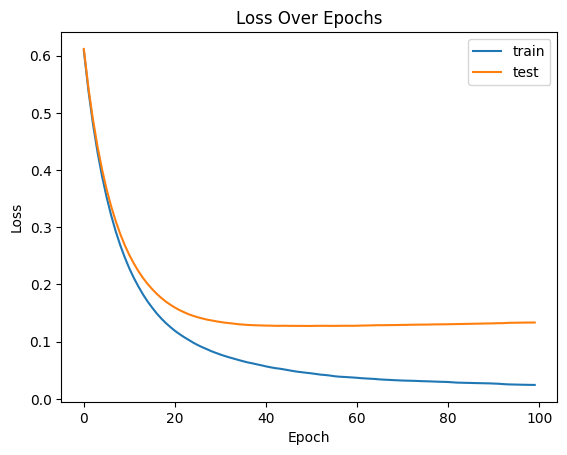

In [107]:
sns.lineplot(evals_results['train']['logloss'], label='train')
sns.lineplot(evals_results['test']['logloss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/xgboost_loss.png', dpi=1200)
plt.show()

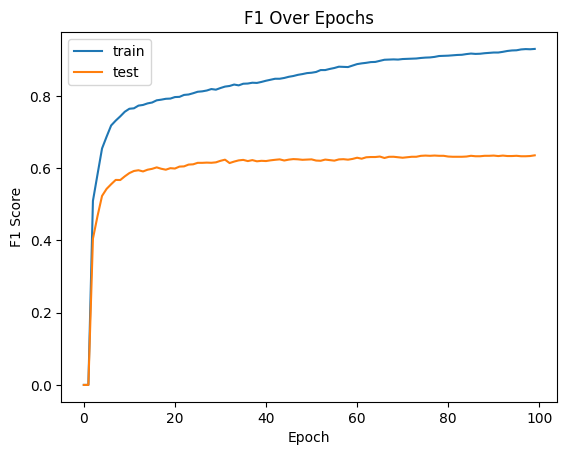

In [109]:
sns.lineplot(evals_results['train']['f1'], label='train')
sns.lineplot(evals_results['test']['f1'], label='test')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/xgboost_F1.png', dpi=1200)
plt.show()

In [99]:
preds = [1 if item > 0.5 else 0 for item in bst.predict(dtest)]
f1_score(test_set.targets, preds)

0.644131455399061

In [106]:
sum(preds == dtest.get_label())/len(preds)

0.9621

In [100]:
bst.save_model('xgb.model')

             importance
ICULOS           1282.0
HospAdmTime      1159.0
Age              1045.0
SBP               957.0
HR                949.0
DBP               916.0
MAP               843.0
Resp              834.0
O2Sat             674.0
Temp              581.0


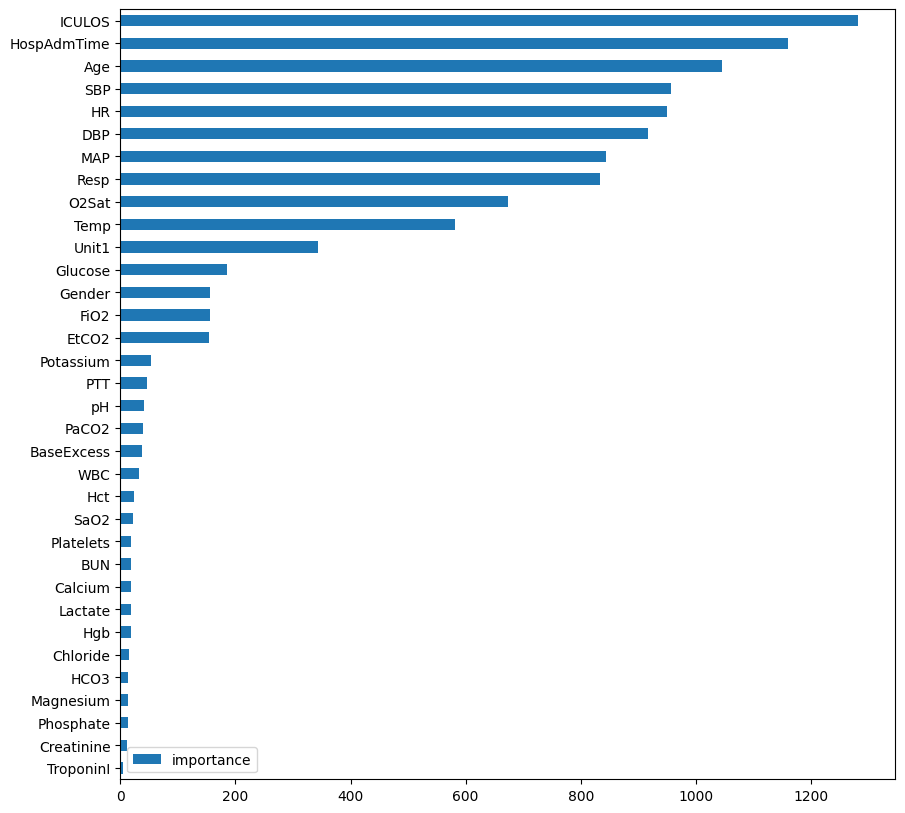

In [110]:
dic = bst.get_score()
columns = pd.read_csv(TRAIN_PATH + 'patient_0.psv', sep='|').columns
dic = {columns[int(key[1:])]: value for key, value in dic.items()}
df = pd.DataFrame(dic.values(), index=dic.keys(), columns=['importance'])
best_features_weight = df.nlargest(10, 'importance').index
print(df.nlargest(10, 'importance'))
df.sort_values('importance').plot(kind='barh', figsize=(10, 10))
plt.savefig('xgboost_feature_importance.png', dpi=1200)
plt.show()

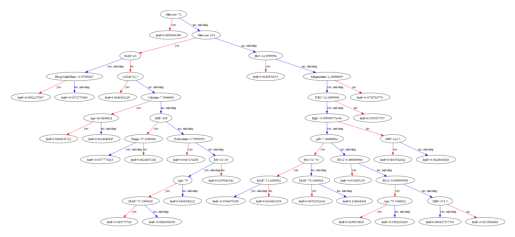

In [35]:
# THIS WILL NOT WORK ON THE VIRTUAL MACHINE, DON'T RUN THIS
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

bst.feature_names = list(pd.read_csv('data/train/patient_0.psv', sep='|').columns[:-1])
xgb.plot_tree(bst, num_trees=99, feature_map='xgb.fmap')
plt.savefig('xgb_tree.png', dpi=1200)
plt.show()

# LSTM
### Dataset

In [46]:
class LSTMDataset(Dataset):
    def __init__(self, path=TRAIN_PATH, pad_to=50, pad=True, pad_value=0, features=None):
        self.data = []
        self.targets = []
        for file in os.listdir(path):
            df = pd.read_csv(os.path.join(path, file), sep='|')
            sepsis_index = df[df['SepsisLabel'] == 1].first_valid_index()
            df = df.drop('SepsisLabel', axis=1)
            if features is not None:
                df = df[features]
            if sepsis_index is not None:
                df = df.iloc[:sepsis_index+1]
                self.targets.append(1)
            else:
                self.targets.append(0)
            df = df.fillna(method='ffill').fillna(method='bfill').fillna(0)
            data = torch.tensor(df.values, dtype=torch.float32)
            self.data.append(data)
            if pad:
                if len(self.data[-1]) < pad_to:
                    self.data[-1] = nn.functional.pad(self.data[-1], (0, 0, 0, pad_to - self.data[-1].shape[0]), value=pad_value)
                else:
                    self.data[-1] = self.data[-1][-pad_to:]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [47]:
lstm_train_dataset = LSTMDataset(pad_to=400)
lstm_test_dataset = LSTMDataset(path=TEST_PATH, pad_to=400)
lstm_train_dataloader = DataLoader(lstm_train_dataset, batch_size=32, shuffle=True)
lstm_test_dataloader = DataLoader(lstm_test_dataset, batch_size=32, shuffle=True)
count_zero = sum([1 for x in lstm_train_dataset.targets if x == 0])
count_one = 20000 - count_zero

### Model

In [45]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size=40, in_channels=400, out_channels=40, hidden_size=128, num_layers=2, lstm_dropout=0.1, fc_dropout=0.1, bidirectional=True, conv_dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.maxpool = nn.MaxPool1d(4)
        self.conv = nn.Sequential(nn.Conv1d(in_channels, out_channels, 3, padding=1), self.maxpool, nn.ReLU(), nn.Dropout(conv_dropout))
        self.lstm = nn.LSTM(int(embedding_size/4), hidden_size, num_layers, dropout=lstm_dropout, batch_first=True, bidirectional=bidirectional)
        self.fc_dropout = nn.Dropout(fc_dropout)
        self.fc = nn.Linear(out_channels*(int(2*hidden_size) if bidirectional else int(hidden_size)), 2)

    def forward(self, x):
        out = self.conv(x)
        out, _ = self.lstm(out)
        out = self.fc_dropout(out)
        out = self.fc(out.reshape(x.shape[0], -1))
        return out

In [ ]:
def lstm_objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 32, 256)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lstm_dropout = trial.suggest_float('lstm_dropout', 0, 0.5)
    fc_dropout = trial.suggest_float('fc_dropout', 0, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    conv_dropout = trial.suggest_float('conv_dropout', 0, 0.5)
    out_channels = trial.suggest_int('out_channels', 1, 40)
    lr = trial.suggest_float('lr', 1e-4, 1e-1)
    model = LSTMModel(hidden_size=hidden_size, num_layers=num_layers, lstm_dropout=lstm_dropout, fc_dropout=fc_dropout, bidirectional=bidirectional, conv_dropout=conv_dropout, out_channels=out_channels)
    model.to(device)
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor([count_zero/count_zero, count_zero/count_one]).to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    num_epochs = 15
    train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, model, lstm_train_dataloader, lstm_test_dataloader, epochs=num_epochs, save_best=False)
    return max(test_f1_scores)

study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(lstm_objective, n_trials=200)

In [ ]:
epochs = 100
lstm = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters())
train_losses, test_losses, train_f1_scores, test_f1_scores = train(criterion, optimizer, lstm, lstm_train_dataloader, lstm_test_dataloader, epochs=epochs, save_best=True, save_name='best_rnn_model.pt')

Epoch: 1 Train Loss: 0.1535326329603791 Test Loss: 0.14122842886625006
Epoch: 2 Train Loss: 0.13652724499627947 Test Loss: 0.14531702557191872
Epoch: 3 Train Loss: 0.13473475745096802 Test Loss: 0.14290661646868474
Epoch: 4 Train Loss: 0.13113763137087225 Test Loss: 0.14010176465462762
Epoch: 5 Train Loss: 0.12828714793249965 Test Loss: 0.13572285595103004
Epoch: 6 Train Loss: 0.1276530026473105 Test Loss: 0.13679595837018454
Epoch: 7 Train Loss: 0.1278652405321598 Test Loss: 0.13316086438683847
Epoch: 8 Train Loss: 0.12555544314235448 Test Loss: 0.13152375160314786
Epoch: 9 Train Loss: 0.12490794807970523 Test Loss: 0.13224928372334271
Epoch: 10 Train Loss: 0.12477658656761051 Test Loss: 0.13761113621830084
Epoch: 11 Train Loss: 0.12367340117394925 Test Loss: 0.13347625203085497
Epoch: 12 Train Loss: 0.12266693766266108 Test Loss: 0.13484861214344684
Epoch: 13 Train Loss: 0.12155261514186859 Test Loss: 0.13554618521905937
Epoch: 14 Train Loss: 0.12166489786505699 Test Loss: 0.13155501

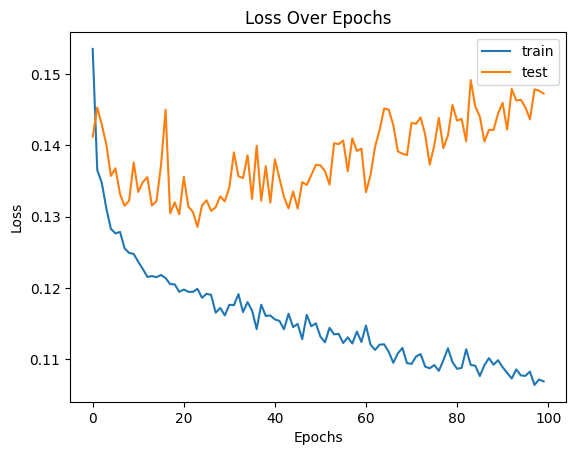

In [19]:
sns.lineplot(train_losses, label='train')
sns.lineplot(test_losses, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/lstm_loss.png', dpi=1200)
plt.show()

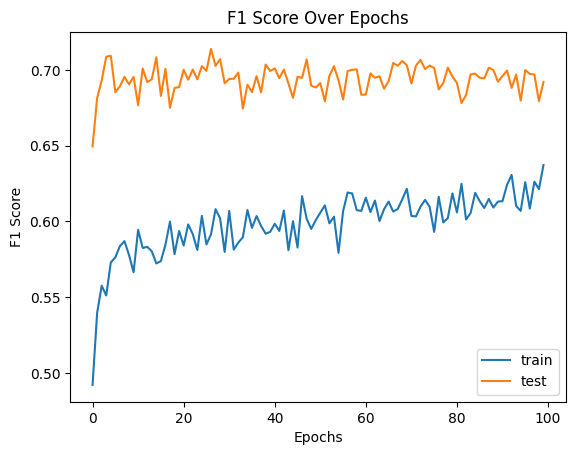

In [20]:
plt.plot(range(epochs), train_f1_scores, label='train')
plt.plot(range(epochs), test_f1_scores, label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.savefig('C:/Users/10/Documents/SemesterB/Lab 2 - Electric Boogaloo/HW1/graphs/lstm_f1.png', dpi=1200)
plt.show()

In [ ]:
max(test_f1_scores)

0.7142857142857142

In [16]:
print(f'best model achieved at epoch {np.argmax(test_f1_scores)} with f1 score of {max(test_f1_scores)}')

best model achieved at epoch 26 with f1 score of 0.7139479905437353


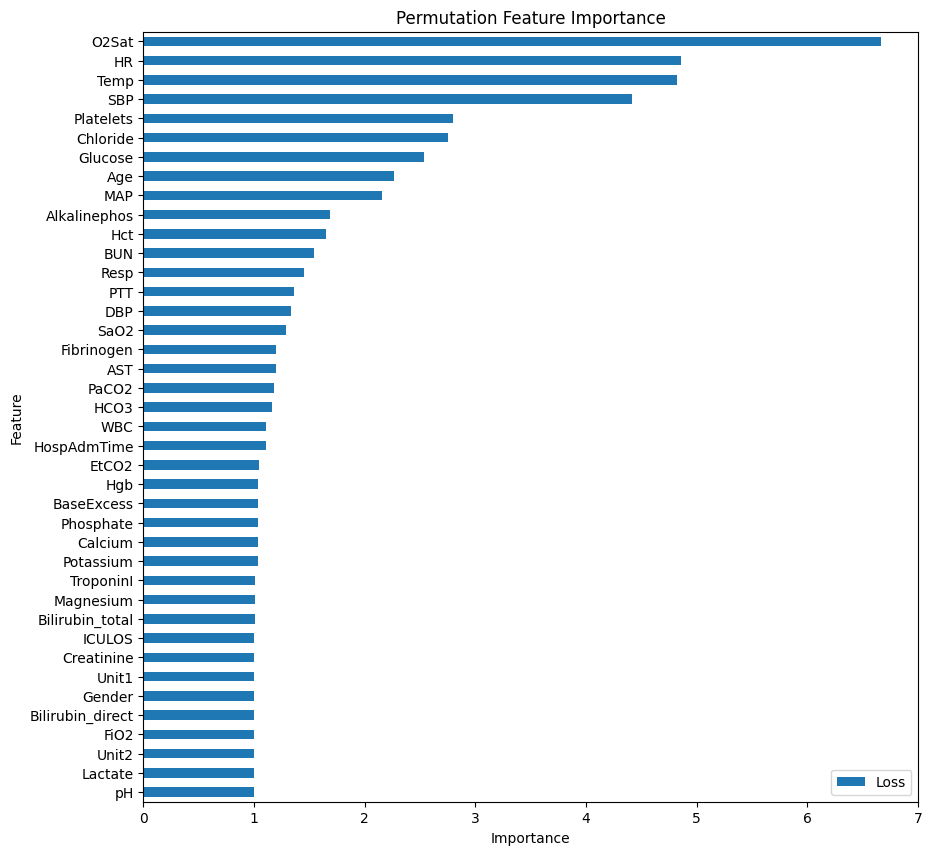

In [75]:
lstm_importance = permutation_feature_importance(lstm, nn.CrossEntropyLoss(), lstm_test_dataset.data, lstm_test_dataset.targets, pd.read_csv('data/train/patient_0.psv', sep='|').columns, lstm=True, device=torch.device('cpu'))
pd.DataFrame(lstm_importance, columns=['Feature', 'Loss']).sort_values('Loss', ascending=True).plot(kind='barh', x='Feature', y='Loss', figsize=(10,10))
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.savefig('lstm_permutation_feature_importance.png', dpi=1200)
plt.show()

In [47]:
lstm.eval()
pred2 = torch.argmax(lstm(torch.vstack(lstm_test_dataset.data).view(-1, 400, 40).to(device)), axis=1)
real2 = torch.Tensor(lstm_test_dataset.targets).to(device)
sum([1 if p == r else 0 for p,r in zip(pred2, real2)])/len(pred2)

0.9622